In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import requests
import json
import geopandas as gpd

# WeGo Public Transit

[WeGo Public Transit](https://www.wegotransit.com/) is a public transit system serving the Greater Nashville
and Davidson County area. WeGo provides local and regional bus routes, the WeGo Star train service connecting
Lebanon to downtown Nashville, along with several other transit services.

In this project, your goal will be to analyze data from WeGo's bus routes and attempt to identify intersections
and other locations which experience frequent delays. This analysis can look by route, by direction of travel,
and by day or day of the week.

You can also consider time of day in your investigation (for example, comparing
the AM and PM rush on Monday through Friday).

You can obtain the data for this project through Swiftly. You will be provided with an API key to  access this data.
The API that you will be using is the [Speed Map API](https://swiftly-inc.stoplight.io/docs/standalone/573bc3fb95867-speed-map),
which provides average speed information for a single route and direction over a given date range.

Note that the API can return either speed data at the stop segment level or return high resolution data,
which provides information for stop segments of approximately 25 meters along with more detailed speed and duration information.

Please take the time to carefully read the API documentation so that you are familiar with the query parameter option
and understand the response data.

You can get more information about these routes, such as route numbers and stop information,
using the [Agency Routes API](https://swiftly-inc.stoplight.io/docs/standalone/5c0bd000bb0f2-agency-routes).
A user-friendly map showing all routes is available at https://www.wegotransit.com/ride/maps-schedules/bus/. 

If time allows, investigate all routes, but start with the high ridership and frequent routes:
* 3: West End
* 7: Hillsboro
* 22: Bordeaux
* 23: Dickerson Pike
* 50: Charlotte Pike
* 52: Nolensville Pike
* 55: Murfreesboro Pike
* 56: Gallatin Pike

Bottlenecks - constant/irregular
(constant)
*ignoring bus stop sections
Finding downtown vs suburbs bottlenecks
1st Quartile of each route for constant
*Delayed data

Focus on Inbound/Outbound
(inbound)

Time categories -
(6am - 9am AM Peak)
9am-230pm Off Peak
230pm-6pm PM Peak
6pm-6am Overnight
Day of Interest
Saturday
Sunday
Holidays*
(M/F)
(Tues-Thurs)
(5/25-7/26)
(1/25-5/24)


# API access
Agency Info: agency_details, routes, schedule

Speed-map: Check all, speed-map



In [2]:
with open('../data/WeGo.json') as fi:
    credentials = json.load(fi)

In [3]:
Authorization = credentials['Authorization']

In [4]:
# URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

# params_geo3 = {
#     'direction': '1',
#     'startDate': '01-07-2022',
#     'endDate': '01-26-2022',
#     'daysOfWeek': '1,2,3,4,5',
#     'beginTime': '06:00',
#     'endTime': '09:00',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'format': 'geojson',
#     'resolution': 'hiRes'
# }

# headers = {'Authorization': Authorization,
#           'Content-Type': 'application/json'}

# response_geo3 = requests.get(URL, params = params_geo3, headers = headers)
# response_geo3

# # dig into json to get list of line-segment dicts
# segments3 = response_geo3.json()['features']

# # convert to GeoDataFrame the quick way
# fullweekgeo = gpd.GeoDataFrame.from_features(segments3)

# fullweekgeo

In [5]:
def concat_frames_columns(geo_response, response, date_range, time_range='6am-9am', days='m-f', in_or_out='inbound'):
    """This function pulls in two API requests, puts one in a geodataframe the other in a dataframe and concats desired columns"""
    geo_df = gpd.GeoDataFrame.from_features(geo_response.json()['features'])
    res_df = pd.DataFrame(response.json()['data']['segments'])
    full_df = pd.concat([geo_df, res_df[['countForSegment', 'percent20Secs']]], axis = 1)
    full_df['dates'] = date_range
    full_df['times'] = time_range
    full_df['days_of_week'] = days
    full_df['direction'] = in_or_out
    full_df['max_seg_count'] = full_df['countForSegment'].max()
    full_df['proportion_of_segments'] = full_df['countForSegment']/full_df['max_seg_count']
    
    return full_df

# Start of M-F, 6am-9am, inbound df, sorted by 30 day chunks Jan 25-July26

In [6]:
# import pygeos
# print(f"pygeos version:  {pygeos.__version__}")
# print(f"geos version: {pygeos.geos_version}")
# print(f"use pygeos? {gpd.options.use_pygeos}")

In [7]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '1',
    'startDate': '01-25-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '02-24-2022',
    'endTime' : '09:00',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '1',
    'startDate': '01-25-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '02-24-2022',
    'endTime' : '09:00',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

mfam_jantofeb = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "1/25/22-2/24/22")

#mfam_jantofeb = mfam_jantofeb.loc[mfam_jantofeb['countForSegment'] > mfam_jantofeb['countForSegment'].max()/2]

mfam_jantofeb

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.139055,11.395219,7.813,3.546,...,1.431,1.285,253,1.490,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.965649
1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.545192,15.212996,4.745,1.828,...,1.247,1.064,245,1.312,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.935115
2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.323759,10.625456,5.661,3.087,...,1.800,1.280,253,1.921,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.965649
3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.678840,9.155829,15.590,4.099,...,1.683,0.969,256,1.843,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.977099
4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.294515,5.689350,27.961,7.016,...,2.407,1.326,241,2.770,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.919847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.607100,9.459553,7.082,3.703,...,1.758,1.368,250,1.928,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.954198
563,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,1.907988,12.663078,6.088,2.620,...,1.448,1.195,258,1.531,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.984733
564,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,7.806658,3.108885,128.807,19.048,...,1.614,1.249,260,1.801,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.992366
565,"LINESTRING (-86.83597 36.15238, -86.83570 36.1...",CXISYLPA,42nd Ave/Sylvan Park Station Inbound,CHA39AEF,Charlotte Ave & 39th Ave N Eb,23.766,3.668957,6.477590,10.161,5.796,...,2.003,0.990,256,2.325,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.977099


In [8]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '1',
    'startDate': '02-25-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '03-26-2022',
    'endTime' : '09:00',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '1',
    'startDate': '02-25-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '03-26-2022',
    'endTime' : '09:00',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

mfam_febtomar = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "2/25/22-3/26/22")

#mfam_febtomar = mfam_febtomar.loc[mfam_febtomar['countForSegment'] > mfam_febtomar['countForSegment'].max()/2]

mfam_febtomar

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.434798,10.011097,15.501,5.232,...,1.445,1.212,188,1.495,2/25/22-3/26/22,6am-9am,m-f,inbound,190,0.989474
1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.522770,15.437000,7.156,1.712,...,1.215,1.006,183,1.311,2/25/22-3/26/22,6am-9am,m-f,inbound,190,0.963158
2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.309017,10.693295,6.581,3.052,...,1.731,1.446,179,1.823,2/25/22-3/26/22,6am-9am,m-f,inbound,190,0.942105
3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.724216,9.003324,8.830,4.169,...,1.802,1.350,190,1.932,2/25/22-3/26/22,6am-9am,m-f,inbound,190,1.000000
4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.248310,5.751228,22.778,6.441,...,2.617,1.577,187,3.019,2/25/22-3/26/22,6am-9am,m-f,inbound,190,0.984211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.694247,9.153578,10.627,3.869,...,1.780,0.921,186,1.992,2/25/22-3/26/22,6am-9am,m-f,inbound,190,0.978947
563,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,1.991113,12.134419,6.393,2.735,...,1.452,1.215,186,1.556,2/25/22-3/26/22,6am-9am,m-f,inbound,190,0.978947
564,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,7.436254,3.263740,50.733,22.845,...,1.637,1.227,189,1.771,2/25/22-3/26/22,6am-9am,m-f,inbound,190,0.994737
565,"LINESTRING (-86.83597 36.15238, -86.83570 36.1...",CXISYLPA,42nd Ave/Sylvan Park Station Inbound,CHA39AEF,Charlotte Ave & 39th Ave N Eb,23.766,3.872550,6.137041,10.443,6.006,...,2.216,1.612,189,2.558,2/25/22-3/26/22,6am-9am,m-f,inbound,190,0.994737


In [9]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '1',
    'startDate': '03-27-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '04-26-2022',
    'endTime' : '09:00',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '1',
    'startDate': '03-27-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '04-26-2022',
    'endTime' : '09:00',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

mfam_martoapr = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "3/27/22-4/26/22")

#mfam_martoapr = mfam_martoapr.loc[mfam_martoapr['countForSegment'] > mfam_martoapr['countForSegment'].max()/2]

mfam_martoapr

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.668957,9.132781,8.657,5.722,...,1.447,0.879,234,1.495,3/27/22-4/26/22,6am-9am,m-f,inbound,242,0.966942
1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.519463,15.470597,5.540,1.733,...,1.257,0.910,229,1.330,3/27/22-4/26/22,6am-9am,m-f,inbound,242,0.946281
2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.374926,10.396534,4.833,3.090,...,1.799,1.484,231,1.949,3/27/22-4/26/22,6am-9am,m-f,inbound,242,0.954545
3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.656868,9.231546,20.947,3.909,...,1.760,1.401,234,1.881,3/27/22-4/26/22,6am-9am,m-f,inbound,242,0.966942
4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.768948,5.123352,40.488,7.445,...,2.621,1.933,233,3.042,3/27/22-4/26/22,6am-9am,m-f,inbound,242,0.962810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.800172,8.807316,8.896,4.011,...,1.870,1.555,233,2.048,3/27/22-4/26/22,6am-9am,m-f,inbound,242,0.962810
563,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,1.985046,12.171506,7.662,2.684,...,1.478,1.269,240,1.578,3/27/22-4/26/22,6am-9am,m-f,inbound,242,0.991736
564,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,7.862739,3.086711,87.073,20.429,...,1.638,1.151,234,1.727,3/27/22-4/26/22,6am-9am,m-f,inbound,242,0.966942
565,"LINESTRING (-86.83597 36.15238, -86.83570 36.1...",CXISYLPA,42nd Ave/Sylvan Park Station Inbound,CHA39AEF,Charlotte Ave & 39th Ave N Eb,23.766,4.034282,5.891011,12.483,6.295,...,2.256,1.695,234,2.542,3/27/22-4/26/22,6am-9am,m-f,inbound,242,0.966942


In [10]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '1',
    'startDate': '04-27-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '05-25-2022',
    'endTime' : '09:00',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '1',
    'startDate': '04-27-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '05-25-2022',
    'endTime' : '09:00',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

mfam_aprtomay = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "4/27/22-5/25/22")

#mfam_aprtomay = mfam_aprtomay.loc[mfam_aprtomay['countForSegment'] > mfam_aprtomay['countForSegment'].max()/2]

mfam_aprtomay

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.875554,8.476627,32.762,5.496,...,1.462,1.254,242,1.525,4/27/22-5/25/22,6am-9am,m-f,inbound,242,1.000000
1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.516862,15.497125,5.337,1.714,...,1.235,0.969,232,1.312,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.958678
2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.418363,10.209799,5.667,3.301,...,1.857,1.348,226,1.935,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.933884
3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.684471,9.136623,6.998,4.191,...,1.756,1.429,242,1.865,4/27/22-5/25/22,6am-9am,m-f,inbound,242,1.000000
4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.265880,5.727540,10.482,6.960,...,2.493,1.779,234,2.980,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.966942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.581885,9.551936,6.928,3.681,...,1.780,1.181,235,1.931,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.971074
562,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,1.968857,12.271587,10.811,2.569,...,1.467,1.149,238,1.557,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.983471
563,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,6.782868,3.578132,84.840,18.202,...,1.621,1.184,242,1.708,4/27/22-5/25/22,6am-9am,m-f,inbound,242,1.000000
564,"LINESTRING (-86.88379 36.14136, -86.88404 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,3.491268,7.114034,8.314,4.714,...,2.457,1.605,239,2.659,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.987603


In [11]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '1',
    'startDate': '05-26-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '06-25-2022',
    'endTime' : '09:00',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '1',
    'startDate': '05-26-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '06-25-2022',
    'endTime' : '09:00',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

mfam_maytojun = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "4/27/22-5/25/22")

#mfam_maytojun = mfam_maytojun.loc[mfam_maytojun['countForSegment'] > mfam_maytojun['countForSegment'].max()/2]

mfam_maytojun

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.532788,9.623782,12.290,5.203,...,1.429,1.139,245,1.498,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.972222
1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.512034,15.546608,5.910,1.685,...,1.243,1.007,235,1.331,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.932540
2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.416913,10.215924,11.560,3.342,...,1.761,1.389,240,1.884,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.952381
3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.760904,8.883684,15.635,4.320,...,1.712,1.401,249,1.894,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.988095
4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.439903,5.503048,10.256,7.044,...,2.709,1.747,247,3.081,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.980159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.638152,9.348210,8.215,3.704,...,1.760,0.971,244,1.990,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.968254
562,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,2.047355,11.801080,19.906,2.980,...,1.487,0.892,248,1.562,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.984127
563,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,7.632524,3.179813,98.684,19.024,...,1.607,1.337,250,1.763,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.992063
564,"LINESTRING (-86.83597 36.15238, -86.83570 36.1...",CXISYLPA,42nd Ave/Sylvan Park Station Inbound,CHA39AEF,Charlotte Ave & 39th Ave N Eb,23.766,3.779992,6.287315,11.217,6.497,...,2.013,1.427,249,2.253,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.988095


In [12]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '1',
    'startDate': '06-26-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '07-26-2022',
    'endTime' : '09:00',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '1',
    'startDate': '06-26-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '07-26-2022',
    'endTime' : '09:00',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

mfam_juntojul = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "4/27/22-5/25/22")

#mfam_juntojul = mfam_juntojul.loc[mfam_juntojul['countForSegment'] > mfam_juntojul['countForSegment'].max()/2]

mfam_juntojul

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.659086,9.166684,9.689,6.150,...,1.445,1.279,233,1.505,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.970833
1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.532767,15.336317,5.864,1.715,...,1.252,0.973,227,1.325,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.945833
2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.286261,10.799729,16.466,2.987,...,1.685,0.747,226,1.815,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.941667
3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.632811,9.315898,14.720,4.046,...,1.678,1.031,233,1.858,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.970833
4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.575500,5.339963,23.075,7.523,...,2.598,1.138,234,3.154,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.975000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.685420,9.183666,8.902,3.746,...,1.876,1.518,238,2.025,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.991667
562,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,1.953690,12.366855,6.845,2.752,...,1.439,1.282,229,1.514,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.954167
563,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,6.419932,3.780414,154.866,17.493,...,1.578,1.315,234,1.693,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.975000
564,"LINESTRING (-86.83597 36.15238, -86.83570 36.1...",CXISYLPA,42nd Ave/Sylvan Park Station Inbound,CHA39AEF,Charlotte Ave & 39th Ave N Eb,23.766,3.739060,6.356143,9.463,5.835,...,1.935,1.480,233,2.315,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.970833


In [13]:
all_am_inschool = pd.concat([mfam_jantofeb, mfam_febtomar, mfam_martoapr, mfam_aprtomay])
all_am_inschool = all_am_inschool.reset_index()

all_am_inschool

,index,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.139055,11.395219,7.813,...,1.431,1.285,253,1.490,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.965649
1,1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.545192,15.212996,4.745,...,1.247,1.064,245,1.312,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.935115
2,2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.323759,10.625456,5.661,...,1.800,1.280,253,1.921,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.965649
3,3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.678840,9.155829,15.590,...,1.683,0.969,256,1.843,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.977099
4,4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.294515,5.689350,27.961,...,2.407,1.326,241,2.770,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.919847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,561,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.581885,9.551936,6.928,...,1.780,1.181,235,1.931,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.971074
2263,562,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,1.968857,12.271587,10.811,...,1.467,1.149,238,1.557,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.983471
2264,563,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,6.782868,3.578132,84.840,...,1.621,1.184,242,1.708,4/27/22-5/25/22,6am-9am,m-f,inbound,242,1.000000
2265,564,"LINESTRING (-86.88379 36.14136, -86.88404 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,3.491268,7.114034,8.314,...,2.457,1.605,239,2.659,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.987603


In [14]:
all_am_summer = pd.concat([mfam_maytojun, mfam_juntojul])
all_am_summer = all_am_summer.reset_index()

all_am_summer

,index,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.532788,9.623782,12.290,...,1.429,1.139,245,1.498,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.972222
1,1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.512034,15.546608,5.910,...,1.243,1.007,235,1.331,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.932540
2,2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.416913,10.215924,11.560,...,1.761,1.389,240,1.884,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.952381
3,3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.760904,8.883684,15.635,...,1.712,1.401,249,1.894,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.988095
4,4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.439903,5.503048,10.256,...,2.709,1.747,247,3.081,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.980159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,561,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.685420,9.183666,8.902,...,1.876,1.518,238,2.025,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.991667
1128,562,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,1.953690,12.366855,6.845,...,1.439,1.282,229,1.514,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.954167
1129,563,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,6.419932,3.780414,154.866,...,1.578,1.315,234,1.693,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.975000
1130,564,"LINESTRING (-86.83597 36.15238, -86.83570 36.1...",CXISYLPA,42nd Ave/Sylvan Park Station Inbound,CHA39AEF,Charlotte Ave & 39th Ave N Eb,23.766,3.739060,6.356143,9.463,...,1.935,1.480,233,2.315,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.970833


In [15]:
am_inschool = all_am_inschool.loc[all_am_inschool['proportion_of_segments'] >= 0.5]\

am_inschool.describe()

,index,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,percent80Secs,percent70Secs,medianSecs,percent30Secs,percent10Secs,minSecs,countForSegment,percent20Secs,max_seg_count,proportion_of_segments
count,2260.00000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000
mean,282.80177,24.452628,3.300496,10.359610,24.995695,5.882825,4.167797,3.285735,2.382921,1.942979,1.650646,1.175879,228.414159,1.802613,234.000000,0.976361
std,163.83248,0.373907,3.972234,3.901991,48.851215,10.691993,7.468676,5.250068,2.117715,0.737111,0.416083,0.293210,26.121844,0.547398,26.689233,0.022246
min,0.00000,23.427000,1.402672,0.499534,1.972000,1.609000,1.518000,1.457000,1.356500,1.280000,1.177000,0.563000,139.000000,1.243000,190.000000,0.731579
25%,141.00000,24.270000,1.809071,7.685138,5.554000,2.162750,1.920250,1.791000,1.638000,1.518000,1.374000,0.999750,190.000000,1.459000,229.000000,0.966942
50%,283.50000,24.486000,2.311541,10.608185,10.366000,3.095000,2.524000,2.262500,1.959000,1.758000,1.541500,1.178000,237.000000,1.658000,242.000000,0.979339
75%,425.00000,24.691000,3.202501,13.556485,25.887750,4.850500,3.677500,3.059500,2.452000,2.110250,1.789250,1.306000,242.000000,1.966000,247.000000,0.991736
max,566.00000,24.929000,49.017718,17.582870,908.216000,111.068000,96.403000,78.093000,41.542000,11.763000,4.785000,2.739000,262.000000,7.856000,262.000000,1.000000


In [16]:
am_inschool

,index,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.139055,11.395219,7.813,...,1.431,1.285,253,1.490,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.965649
1,1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.545192,15.212996,4.745,...,1.247,1.064,245,1.312,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.935115
2,2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.323759,10.625456,5.661,...,1.800,1.280,253,1.921,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.965649
3,3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.678840,9.155829,15.590,...,1.683,0.969,256,1.843,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.977099
4,4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.294515,5.689350,27.961,...,2.407,1.326,241,2.770,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.919847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,561,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.581885,9.551936,6.928,...,1.780,1.181,235,1.931,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.971074
2263,562,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,1.968857,12.271587,10.811,...,1.467,1.149,238,1.557,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.983471
2264,563,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,6.782868,3.578132,84.840,...,1.621,1.184,242,1.708,4/27/22-5/25/22,6am-9am,m-f,inbound,242,1.000000
2265,564,"LINESTRING (-86.88379 36.14136, -86.88404 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,3.491268,7.114034,8.314,...,2.457,1.605,239,2.659,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.987603


In [17]:
am_summer = all_am_summer.loc[all_am_summer['proportion_of_segments'] >= 0.5]\

am_summer.describe()

,index,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,percent80Secs,percent70Secs,medianSecs,percent30Secs,percent10Secs,minSecs,countForSegment,percent20Secs,max_seg_count,proportion_of_segments
count,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000
mean,282.504425,24.452628,3.287848,10.666016,24.711032,5.814158,4.222130,3.373173,2.424277,1.956472,1.618922,1.117849,239.614159,1.796961,246.000000,0.973958
std,163.606775,0.373990,4.290944,4.095163,56.539483,11.143006,8.047563,5.834034,2.576865,0.971432,0.405034,0.297518,8.170231,0.582937,6.002657,0.019339
min,0.000000,23.427000,1.389111,0.508919,2.042000,1.612000,1.520000,1.428000,1.355000,1.259000,1.160000,0.622000,188.000000,1.218000,240.000000,0.753968
25%,141.000000,24.270000,1.765278,7.771503,4.732500,2.119250,1.892000,1.751750,1.616625,1.509000,1.356000,0.965000,234.000000,1.452250,240.000000,0.966667
50%,283.000000,24.486000,2.270066,10.807093,7.953000,2.967000,2.481500,2.228000,1.946250,1.742500,1.512000,1.102000,237.000000,1.647000,246.000000,0.979167
75%,424.000000,24.691000,3.149889,13.895917,21.409500,4.626750,3.662750,3.024250,2.435375,2.117750,1.744750,1.260000,248.000000,1.957000,252.000000,0.987500
max,565.000000,24.929000,48.113787,17.754521,952.070000,108.863000,90.760000,77.546000,47.603000,17.537000,5.257000,2.662000,252.000000,8.654000,252.000000,1.000000


<AxesSubplot:>

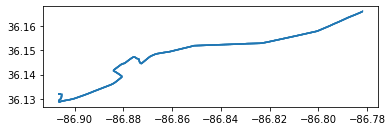

In [18]:
am_inschool.plot()

<AxesSubplot:>

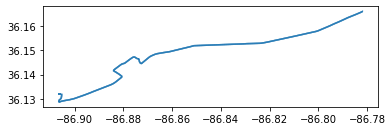

In [19]:
am_summer.plot()

In [20]:
# Class Focus
# Time categories
# 6-9am AM peak (inbound)
# 9am-2:30pm off peak (inbound & outbound)
# 2:30-6pm PM peak (outbound)
# 6pm-6am overnight (inbound & outbound)
# Days of interest
# M-F
# What to focus on
# Keep all segments/problem areas
# Recognize downtown stops, not focusing on that area
# Highlight the interesting areas for each route (number may vary based on findings for each route)

In [47]:
morning_inschool_inbound = am_inschool.loc[am_inschool['percent20Secs'] > np.quantile(am_inschool['percent20Secs'], .80)]
morning_inschool_inbound

,index,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
4,4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.294515,5.689350,27.961,...,2.407,1.326,241,2.770,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.919847
7,7,"LINESTRING (-86.88358 36.14213, -86.88338 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,2.997582,8.285678,21.631,...,2.095,0.641,249,2.194,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.950382
13,13,"LINESTRING (-86.90532 36.13195, -86.90533 36.1...",WALMARTC,Walmart,CXIDVDSN,Davidson Station Inbound,24.486,4.674716,5.237965,10.863,...,2.781,0.796,257,3.070,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.980916
18,18,"LINESTRING (-86.85828 36.15004, -86.85801 36.1...",CXIWTBRG,White Bridge Station Inbound,CXI53AVE,53rd Ave Station Inbound,24.864,38.414932,0.647248,117.462,...,2.146,1.443,251,2.984,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.958015
20,20,"LINESTRING (-86.87258 36.14451, -86.87239 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,3.848581,6.348574,27.474,...,2.403,1.326,248,2.720,1/25/22-2/24/22,6am-9am,m-f,inbound,262,0.946565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,548,"LINESTRING (-86.88354 36.14125, -86.88379 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,3.431937,7.237021,61.125,...,2.086,1.170,239,2.427,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.987603
2257,556,"LINESTRING (-86.90653 36.12874, -86.90646 36.1...",WALMARTC,Walmart,CXIDVDSN,Davidson Station Inbound,24.486,13.527062,1.810149,125.478,...,3.524,2.516,241,4.063,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.995868
2258,557,"LINESTRING (-86.87220 36.14482, -86.87201 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,5.545489,4.405923,30.956,...,2.097,1.646,235,2.466,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.971074
2265,564,"LINESTRING (-86.88379 36.14136, -86.88404 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,3.491268,7.114034,8.314,...,2.457,1.605,239,2.659,4/27/22-5/25/22,6am-9am,m-f,inbound,242,0.987603


In [48]:
morning_summer_inbound = am_summer.loc[am_summer['percent20Secs'] > np.quantile(am_summer['percent20Secs'], .80)]
morning_summer_inbound

,index,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
4,4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.439903,5.503048,10.256,...,2.709,1.747,247,3.081,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.980159
6,6,"LINESTRING (-86.87163 36.14530, -86.87143 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.971596,8.299244,7.743,...,1.850,0.971,245,2.103,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.972222
7,7,"LINESTRING (-86.88358 36.14213, -86.88338 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,2.653538,9.359956,6.189,...,2.092,0.942,247,2.264,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.980159
11,11,"LINESTRING (-86.81867 36.15379, -86.81841 36.1...",CHA33AEN,Charlotte Ave & 33rd Ave N,CXI2831,28th/31st Ave Connector Station Inbound,24.664,14.304514,1.724211,109.287,...,1.775,1.119,247,2.384,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.980159
13,13,"LINESTRING (-86.90532 36.13195, -86.90533 36.1...",WALMARTC,Walmart,CXIDVDSN,Davidson Station Inbound,24.486,4.741640,5.164036,12.803,...,1.337,0.622,250,3.089,4/27/22-5/25/22,6am-9am,m-f,inbound,252,0.992063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,549,"LINESTRING (-86.88354 36.14125, -86.88379 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,2.999249,8.281073,8.792,...,2.058,0.939,237,2.285,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.987500
1122,556,"LINESTRING (-86.90653 36.12874, -86.90646 36.1...",WALMARTC,Walmart,CXIDVDSN,Davidson Station Inbound,24.486,15.798915,1.549853,122.033,...,3.452,1.093,235,4.024,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.979167
1123,557,"LINESTRING (-86.87220 36.14482, -86.87201 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,5.761123,4.241013,36.521,...,2.157,1.504,236,2.457,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.983333
1130,564,"LINESTRING (-86.83597 36.15238, -86.83570 36.1...",CXISYLPA,42nd Ave/Sylvan Park Station Inbound,CHA39AEF,Charlotte Ave & 39th Ave N Eb,23.766,3.739060,6.356143,9.463,...,1.935,1.480,233,2.315,4/27/22-5/25/22,6am-9am,m-f,inbound,240,0.970833


<AxesSubplot:>

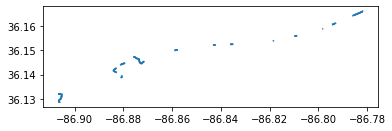

In [49]:
morning_inschool_inbound.plot()

<AxesSubplot:>

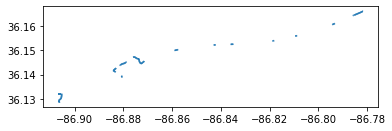

In [50]:
morning_summer_inbound.plot()

# Start of M-F, 9am-2:30am, OFF PEAK inbound df, sorted by 30 day chunks Jan 25-July26

In [25]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '1',
    'startDate': '01-25-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '02-24-2022',
    'endTime' : '14:30',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '1',
    'startDate': '01-25-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '02-24-2022',
    'endTime' : '14:30',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

jantofeb_offpeak_inbound = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "1/25/22-2/24/22")

#jantofeb_offpeak_inbound = jantofeb_offpeak_inbound.loc[jantofeb_offpeak_inbound['countForSegment'] > jantofeb_offpeak_inbound['countForSegment'].max()/2]

jantofeb_offpeak_inbound

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.335210,10.438033,10.456,4.300,...,1.455,1.266,467,1.514,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.970894
1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.903534,12.349136,31.918,2.311,...,1.361,1.161,464,1.448,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.964657
2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.353768,10.489989,8.571,3.064,...,1.642,1.030,469,1.838,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.975052
3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,3.110314,7.885699,148.750,4.073,...,1.706,1.283,472,1.936,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.981289
4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.633269,5.273383,51.467,7.850,...,2.487,1.872,453,2.832,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.941788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.533658,9.733753,8.498,3.728,...,1.763,0.736,471,1.942,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.979210
563,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,2.477821,9.750906,21.423,3.665,...,1.523,1.212,463,1.649,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.962578
564,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,17.253112,1.406703,333.091,33.611,...,1.685,1.254,472,1.900,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.981289
565,"LINESTRING (-86.83597 36.15238, -86.83570 36.1...",CXISYLPA,42nd Ave/Sylvan Park Station Inbound,CHA39AEF,Charlotte Ave & 39th Ave N Eb,23.766,4.418394,5.378877,34.705,6.990,...,2.382,1.486,469,2.662,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.975052


In [26]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '1',
    'startDate': '02-25-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '03-26-2022',
    'endTime' : '14:30',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '1',
    'startDate': '02-25-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '03-26-2022',
    'endTime' : '14:30',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

febtomar_offpeak_inbound = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "2/25/22-3/26/22")

#mfam_febtomar = mfam_febtomar.loc[mfam_febtomar['countForSegment'] > mfam_febtomar['countForSegment'].max()/2]

febtomar_offpeak_inbound

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,2.143988,10.964147,11.491,4.039,...,1.389,1.108,344,1.442,2/25/22-3/26/22,6am-9am,m-f,inbound,348,0.988506
1,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.753523,8.907498,9.096,4.055,...,1.764,1.265,346,1.952,2/25/22-3/26/22,6am-9am,m-f,inbound,348,0.994253
2,"LINESTRING (-86.79316 36.16427, -86.79291 36.1...",MLK,Martin Luther King School,MCC5_11,Central 5th Ave - Bay 11,24.969,2.608000,9.574003,2.608,2.608,...,2.608,2.608,1,2.608,2/25/22-3/26/22,6am-9am,m-f,inbound,348,0.002874
3,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,5.005178,4.881545,82.358,7.648,...,2.380,1.519,331,2.668,2/25/22-3/26/22,6am-9am,m-f,inbound,348,0.951149
4,"LINESTRING (-86.88358 36.14213, -86.88338 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,2.653610,9.359702,36.856,3.149,...,2.040,0.707,331,2.194,2/25/22-3/26/22,6am-9am,m-f,inbound,348,0.951149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,"LINESTRING (-86.85218 36.15152, -86.85192 36.1...",CXIWTBRG,White Bridge Station Inbound,CXI53AVE,53rd Ave Station Inbound,24.864,2.677925,9.284801,17.690,4.159,...,1.631,1.128,347,1.773,2/25/22-3/26/22,6am-9am,m-f,inbound,348,0.997126
810,"LINESTRING (-86.78612 36.16793, -86.78590 36.1...",MLK,Martin Luther King School,MCC5_11,Central 5th Ave - Bay 11,24.969,2.148000,11.624302,2.148,2.148,...,2.148,2.148,1,2.148,2/25/22-3/26/22,6am-9am,m-f,inbound,348,0.002874
811,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.695348,9.149839,11.297,3.829,...,1.791,1.505,342,1.933,2/25/22-3/26/22,6am-9am,m-f,inbound,348,0.982759
812,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,2.307751,10.469500,28.954,3.160,...,1.542,1.303,345,1.624,2/25/22-3/26/22,6am-9am,m-f,inbound,348,0.991379


In [27]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '1',
    'startDate': '03-27-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '04-26-2022',
    'endTime' : '14:30',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '1',
    'startDate': '03-27-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '04-26-2022',
    'endTime' : '14:30',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

martoapr_offpeak_inbound = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "3/27/22-4/26/22")

#mfam_martoapr = mfam_martoapr.loc[mfam_martoapr['countForSegment'] > mfam_martoapr['countForSegment'].max()/2]

martoapr_offpeak_inbound

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.802037,8.699029,55.707,4.960,...,1.471,1.269,432,1.567,3/27/22-4/26/22,6am-9am,m-f,inbound,442,0.977376
1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.858753,12.646651,7.722,2.211,...,1.345,1.103,433,1.422,3/27/22-4/26/22,6am-9am,m-f,inbound,442,0.979638
2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.949133,8.372291,81.132,3.218,...,1.727,1.330,437,1.899,3/27/22-4/26/22,6am-9am,m-f,inbound,442,0.988688
3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.826453,8.677661,10.959,4.057,...,1.868,1.435,437,2.064,3/27/22-4/26/22,6am-9am,m-f,inbound,442,0.988688
4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.692290,5.207052,47.551,7.743,...,2.515,1.852,428,2.799,3/27/22-4/26/22,6am-9am,m-f,inbound,442,0.968326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.549495,9.673288,16.313,3.618,...,1.765,1.523,436,1.912,3/27/22-4/26/22,6am-9am,m-f,inbound,442,0.986425
563,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,2.345723,10.300023,13.916,3.263,...,1.550,1.299,437,1.657,3/27/22-4/26/22,6am-9am,m-f,inbound,442,0.988688
564,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,18.316705,1.325020,200.439,48.343,...,1.732,1.213,441,2.022,3/27/22-4/26/22,6am-9am,m-f,inbound,442,0.997738
565,"LINESTRING (-86.83597 36.15238, -86.83570 36.1...",CXISYLPA,42nd Ave/Sylvan Park Station Inbound,CHA39AEF,Charlotte Ave & 39th Ave N Eb,23.766,4.423459,5.372718,24.414,7.273,...,2.494,0.985,436,2.753,3/27/22-4/26/22,6am-9am,m-f,inbound,442,0.986425


In [28]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '1',
    'startDate': '04-27-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '05-25-2022',
    'endTime' : '14:30',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '1',
    'startDate': '04-27-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '05-25-2022',
    'endTime' : '14:30',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

aprtomay_offpeak_inbound = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "4/27/22-5/25/22")

#mfam_aprtomay = mfam_aprtomay.loc[mfam_aprtomay['countForSegment'] > mfam_aprtomay['countForSegment'].max()/2]

aprtomay_offpeak_inbound

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,minSecs,numTrips,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.793427,13.107308,6.707,2.237,...,1.113,NaN,443,1.423,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.980088
1,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.831172,8.663197,6.998,4.254,...,1.129,NaN,441,2.035,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.975664
2,"LINESTRING (-86.79316 36.16427, -86.79291 36.1...",MLK,Martin Luther King School,MCC5_11,Central 5th Ave - Bay 11,24.969,9.498500,2.628731,30.994,30.994,...,0.892,NaN,4,0.892,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.008850
3,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.565368,5.351814,29.047,7.469,...,1.976,NaN,451,2.994,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.997788
4,"LINESTRING (-86.88358 36.14213, -86.88338 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,2.578623,9.631885,9.929,3.148,...,0.913,NaN,446,2.227,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.986726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,"LINESTRING (-86.85218 36.15152, -86.85192 36.1...",CXIWTBRG,White Bridge Station Inbound,CXI53AVE,53rd Ave Station Inbound,24.864,2.932932,8.477524,26.111,4.450,...,1.234,NaN,443,1.831,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.980088
910,"LINESTRING (-86.78612 36.16793, -86.78590 36.1...",MLK,Martin Luther King School,MCC5_11,Central 5th Ave - Bay 11,24.969,1.887250,13.230362,2.282,2.282,...,0.892,NaN,4,0.892,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.008850
911,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.570948,9.592571,12.029,3.549,...,1.439,NaN,445,1.985,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.984513
912,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,2.602237,9.284704,25.265,3.705,...,1.212,NaN,439,1.672,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.971239


In [29]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '1',
    'startDate': '05-26-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '06-25-2022',
    'endTime' : '14:30',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '1',
    'startDate': '05-26-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '06-25-2022',
    'endTime' : '14:30',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

maytojun_offpeak_inbound = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "4/27/22-5/25/22")

#mfam_maytojun = mfam_maytojun.loc[mfam_maytojun['countForSegment'] > mfam_maytojun['countForSegment'].max()/2]

maytojun_offpeak_inbound

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.862694,12.619894,7.125,2.442,...,1.354,1.041,447,1.432,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.963362
1,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.857044,8.584747,29.360,4.167,...,1.810,1.232,458,2.033,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.987069
2,"LINESTRING (-86.79316 36.16427, -86.79291 36.1...",MLK,Martin Luther King School,MCC5_11,Central 5th Ave - Bay 11,24.969,10.836000,2.304264,10.836,10.836,...,10.836,10.836,1,10.836,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.002155
3,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.706330,5.191519,69.660,7.697,...,2.727,1.666,464,3.086,4/27/22-5/25/22,6am-9am,m-f,inbound,464,1.000000
4,"LINESTRING (-86.88358 36.14213, -86.88338 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,2.659249,9.339855,19.569,3.207,...,2.073,0.656,458,2.220,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.987069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,"LINESTRING (-86.85218 36.15152, -86.85192 36.1...",CXIWTBRG,White Bridge Station Inbound,CXI53AVE,53rd Ave Station Inbound,24.864,2.926996,8.494716,18.945,4.332,...,1.688,1.265,460,1.837,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.991379
908,"LINESTRING (-86.78612 36.16793, -86.78590 36.1...",MLK,Martin Luther King School,MCC5_11,Central 5th Ave - Bay 11,24.969,2.199000,11.354707,2.199,2.199,...,2.199,2.199,1,2.199,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.002155
909,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.620430,9.411432,17.962,3.508,...,1.807,1.501,451,1.988,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.971983
910,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,2.316387,10.430468,15.742,3.439,...,1.537,1.042,452,1.651,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.974138


In [30]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '1',
    'startDate': '06-26-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '07-26-2022',
    'endTime' : '14:30',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '1',
    'startDate': '06-26-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '07-26-2022',
    'endTime' : '14:30',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

juntojul_offpeak_inbound = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "4/27/22-5/25/22")

#mfam_juntojul = mfam_juntojul.loc[mfam_juntojul['countForSegment'] > mfam_juntojul['countForSegment'].max()/2]

juntojul_offpeak_inbound

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.401033,10.151880,8.202,4.583,...,1.477,1.239,453,1.539,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.986928
1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.889834,12.438659,7.375,2.501,...,1.370,1.100,446,1.459,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.971678
2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.432921,10.148706,34.154,3.118,...,1.688,1.300,453,1.815,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.986928
3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,3.110683,7.884764,76.442,4.197,...,1.852,1.283,454,2.035,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.989107
4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.532634,5.390464,11.080,7.719,...,2.583,2.004,456,3.076,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.993464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.736563,9.012034,34.365,3.677,...,1.806,1.125,444,1.967,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.967320
562,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,2.238993,10.791012,11.506,3.370,...,1.525,1.260,451,1.638,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.982571
563,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,18.561211,1.307566,295.435,48.697,...,1.796,1.384,454,2.035,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.989107
564,"LINESTRING (-86.83597 36.15238, -86.83570 36.1...",CXISYLPA,42nd Ave/Sylvan Park Station Inbound,CHA39AEF,Charlotte Ave & 39th Ave N Eb,23.766,3.984716,5.964290,15.257,6.199,...,2.272,0.979,455,2.626,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.991285


In [31]:
offpeak_inschool = pd.concat([jantofeb_offpeak_inbound, febtomar_offpeak_inbound, martoapr_offpeak_inbound, aprtomay_offpeak_inbound])
offpeak_inschool = offpeak_inschool.reset_index()

offpeak_inschool

,index,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,...,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments,numTrips
0,0,"LINESTRING (-86.83200 36.15252, -86.83173 36.1...",CHA39AEF,Charlotte Ave & 39th Ave N Eb,CXISYLHE,37th Ave/Sylvan Heights Station Inbound,24.375,2.335210,10.438033,10.456,...,1.266,467,1.514,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.970894,NaN
1,1,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.903534,12.349136,31.918,...,1.161,464,1.448,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.964657,NaN
2,2,"LINESTRING (-86.79194 36.16148, -86.79169 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,2.353768,10.489989,8.571,...,1.030,469,1.838,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.975052,NaN
3,3,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,3.110314,7.885699,148.750,...,1.283,472,1.936,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.981289,NaN
4,4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.633269,5.273383,51.467,...,1.872,453,2.832,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.941788,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,909,"LINESTRING (-86.85218 36.15152, -86.85192 36.1...",CXIWTBRG,White Bridge Station Inbound,CXI53AVE,53rd Ave Station Inbound,24.864,2.932932,8.477524,26.111,...,1.234,443,1.831,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.980088,NaN
2858,910,"LINESTRING (-86.78612 36.16793, -86.78590 36.1...",MLK,Martin Luther King School,MCC5_11,Central 5th Ave - Bay 11,24.969,1.887250,13.230362,2.282,...,0.892,4,0.892,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.008850,NaN
2859,911,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.570948,9.592571,12.029,...,1.439,445,1.985,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.984513,NaN
2860,912,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,2.602237,9.284704,25.265,...,1.212,439,1.672,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.971239,NaN


In [32]:
offpeak_summer_in = pd.concat([maytojun_offpeak_inbound, juntojul_offpeak_inbound])
offpeak_summer_in = offpeak_summer_in.reset_index()

offpeak_summer_in

,index,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
0,0,"LINESTRING (-86.86416 36.14888, -86.86390 36.1...",CHABALEF,Charlotte Ave & Balmy Ave Eb,CHALELEM,Charlotte Pike & Lellyett St Eb,23.507,1.862694,12.619894,7.125,...,1.354,1.041,447,1.432,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.963362
1,1,"LINESTRING (-86.84193 36.15216, -86.84166 36.1...",CXIRICHL,46th Ave/Richland Park Station Inbound,CXISYLPA,42nd Ave/Sylvan Park Station Inbound,24.527,2.857044,8.584747,29.360,...,1.810,1.232,458,2.033,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.987069
2,2,"LINESTRING (-86.79316 36.16427, -86.79291 36.1...",MLK,Martin Luther King School,MCC5_11,Central 5th Ave - Bay 11,24.969,10.836000,2.304264,10.836,...,10.836,10.836,1,10.836,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.002155
3,3,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.706330,5.191519,69.660,...,2.727,1.666,464,3.086,4/27/22-5/25/22,6am-9am,m-f,inbound,464,1.000000
4,4,"LINESTRING (-86.88358 36.14213, -86.88338 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,2.659249,9.339855,19.569,...,2.073,0.656,458,2.220,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.987069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473,561,"LINESTRING (-86.87143 36.14546, -86.87124 36.1...",CXIAMERI,American Station Inbound,CHABALEF,Charlotte Ave & Balmy Ave Eb,24.662,2.736563,9.012034,34.365,...,1.806,1.125,444,1.967,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.967320
1474,562,"LINESTRING (-86.80505 36.15676, -86.80479 36.1...",CXICENTE,23rd Ave / Centennial Station Inbound,CHA20AEF,Charlotte Ave & 20th Ave Eb,24.161,2.238993,10.791012,11.506,...,1.525,1.260,451,1.638,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.982571
1475,563,"LINESTRING (-86.85058 36.15184, -86.85031 36.1...",CXI53AVE,53rd Ave Station Inbound,CXIRICHL,46th Ave/Richland Park Station Inbound,24.270,18.561211,1.307566,295.435,...,1.796,1.384,454,2.035,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.989107
1476,564,"LINESTRING (-86.83597 36.15238, -86.83570 36.1...",CXISYLPA,42nd Ave/Sylvan Park Station Inbound,CHA39AEF,Charlotte Ave & 39th Ave N Eb,23.766,3.984716,5.964290,15.257,...,2.272,0.979,455,2.626,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.991285


In [33]:
offpeak_inschool_in = offpeak_inschool.loc[offpeak_inschool['proportion_of_segments'] >= 0.5]\

offpeak_inschool_in.describe()

,index,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,percent80Secs,percent70Secs,medianSecs,percent30Secs,percent10Secs,minSecs,countForSegment,percent20Secs,max_seg_count,proportion_of_segments,numTrips
count,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,0.0
mean,351.392920,24.452628,3.555537,9.416467,39.160167,6.359928,4.411346,3.482927,2.442702,2.001480,1.697605,1.076637,419.658407,1.853769,430.750000,0.974886,NaN
std,220.444761,0.373907,4.038710,3.508826,68.860471,10.945501,7.696240,5.623453,1.506668,0.637615,0.406212,0.332766,47.451521,0.504335,49.887761,0.023688,NaN
min,0.000000,23.427000,1.455719,0.431969,2.449000,1.737000,1.628000,1.529000,1.396000,1.277000,1.147000,0.256000,274.000000,1.222000,348.000000,0.752599,NaN
25%,170.000000,24.270000,2.006651,6.905694,8.248250,2.507750,2.159750,1.981000,1.756500,1.594000,1.417000,0.907000,348.000000,1.521750,418.500000,0.968815,NaN
50%,335.000000,24.486000,2.521536,9.733153,17.786500,3.541500,2.797000,2.421000,2.068500,1.835000,1.609000,1.108000,439.000000,1.729500,447.000000,0.980088,NaN
75%,504.000000,24.691000,3.538172,12.170443,41.898000,5.506250,4.009500,3.305250,2.607000,2.171250,1.815500,1.266000,447.000000,2.007250,459.250000,0.988506,NaN
max,913.000000,24.929000,57.559660,16.942143,902.330000,149.292000,124.630000,104.143000,23.906000,6.729000,4.083000,2.435000,481.000000,5.283000,481.000000,1.000000,NaN


In [34]:
offpeak_inschool_inbound = offpeak_inschool_in.loc[offpeak_inschool_in['percent20Secs'] > np.quantile(offpeak_inschool_in['percent20Secs'], .80)]

offpeak_inschool_inbound

,index,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,...,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments,numTrips
4,4,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.633269,5.273383,51.467,...,1.872,453,2.832,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.941788,NaN
7,7,"LINESTRING (-86.88358 36.14213, -86.88338 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,2.635751,9.423121,32.884,...,1.058,446,2.126,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.927235,NaN
11,11,"LINESTRING (-86.81867 36.15379, -86.81841 36.1...",CHA33AEN,Charlotte Ave & 33rd Ave N,CXI2831,28th/31st Ave Connector Station Inbound,24.664,12.985645,1.899328,124.683,...,1.272,462,2.173,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.960499,NaN
13,13,"LINESTRING (-86.90532 36.13195, -86.90533 36.1...",WALMARTC,Walmart,CXIDVDSN,Davidson Station Inbound,24.486,5.113884,4.788141,21.077,...,0.719,473,3.280,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.983368,NaN
18,18,"LINESTRING (-86.85828 36.15004, -86.85801 36.1...",CXIWTBRG,White Bridge Station Inbound,CXI53AVE,53rd Ave Station Inbound,24.864,57.559660,0.431969,590.177,...,1.506,474,2.984,1/25/22-2/24/22,6am-9am,m-f,inbound,481,0.985447,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,810,"LINESTRING (-86.78222 36.16567, -86.78197 36.1...",CHA7AEN,Charlotte Ave & 7th Ave N Eb,MCC5_1,Central 5th Ave - Bay 1,24.860,4.579451,5.428598,32.113,...,1.887,384,2.961,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.849558,NaN
2803,855,"LINESTRING (-86.79823 36.15874, -86.79799 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,5.698395,4.332974,44.703,...,1.384,438,2.343,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.969027,NaN
2805,857,"LINESTRING (-86.79847 36.15864, -86.79823 36.1...",CHA20AEF,Charlotte Ave & 20th Ave Eb,CXI17AVE,17th Ave Station Inbound,24.207,15.422872,1.569552,141.930,...,1.326,439,2.371,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.971239,NaN
2814,866,"LINESTRING (-86.79799 36.15884, -86.79774 36.1...",CXI17AVE,17th Ave Station Inbound,CXINGULC,11th Ave / N Gulch Station Inbound,24.691,3.523559,7.007404,16.250,...,1.425,438,2.219,4/27/22-5/25/22,6am-9am,m-f,inbound,452,0.969027,NaN


In [35]:
offpeak_summer_inbound = offpeak_summer_in.loc[offpeak_summer_in['proportion_of_segments'] >= 0.5]\

offpeak_summer_inbound.describe()

,index,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,percent80Secs,percent70Secs,medianSecs,percent30Secs,percent10Secs,minSecs,countForSegment,percent20Secs,max_seg_count,proportion_of_segments
count,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000
mean,363.343363,24.452628,3.542093,9.414201,34.267780,6.423949,4.497325,3.563169,2.492766,2.037827,1.719319,1.184485,452.566372,1.883181,461.500000,0.980659
std,230.981663,0.373990,3.927640,3.446024,60.573077,11.044261,7.676516,5.437033,1.546967,0.656865,0.399220,0.306659,10.340249,0.508465,2.501107,0.022478
min,0.000000,23.427000,1.525522,0.500349,2.811000,1.897000,1.736000,1.628000,1.455000,1.353000,1.223000,0.652000,343.000000,1.298000,459.000000,0.739224
25%,175.250000,24.270000,2.013882,6.975726,7.530500,2.552250,2.213000,2.027000,1.795750,1.618000,1.439000,0.995500,450.000000,1.537500,459.000000,0.976035
50%,341.500000,24.486000,2.515664,9.738351,14.424000,3.499000,2.844500,2.459000,2.114500,1.869000,1.631000,1.195000,454.000000,1.761500,461.500000,0.987069
75%,514.750000,24.691000,3.519820,12.167654,39.277000,5.442750,3.973000,3.308750,2.645750,2.221500,1.841000,1.310000,457.000000,2.041750,464.000000,0.989224
max,911.000000,24.929000,49.693280,16.166925,1219.751000,134.566000,104.638000,82.653000,22.141000,7.267000,4.179000,2.614000,464.000000,5.324000,464.000000,1.000000


In [36]:
offpeak_summer_inbound = offpeak_summer_in.loc[offpeak_summer_in['percent20Secs'] > np.quantile(offpeak_summer_in['percent20Secs'], .80)]

offpeak_summer_inbound

,index,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,times,days_of_week,direction,max_seg_count,proportion_of_segments
2,2,"LINESTRING (-86.79316 36.16427, -86.79291 36.1...",MLK,Martin Luther King School,MCC5_11,Central 5th Ave - Bay 11,24.969,10.836000,2.304264,10.836,...,10.836,10.836,1,10.836,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.002155
3,3,"LINESTRING (-86.87277 36.14445, -86.87258 36.1...",PREWILNN,Premier Dr & Wilclay Dr Nb,CXIAMERI,American Station Inbound,24.433,4.706330,5.191519,69.660,...,2.727,1.666,464,3.086,4/27/22-5/25/22,6am-9am,m-f,inbound,464,1.000000
10,10,"LINESTRING (-86.90532 36.13195, -86.90533 36.1...",WALMARTC,Walmart,CXIDVDSN,Davidson Station Inbound,24.486,5.451239,4.491823,12.385,...,2.922,0.802,461,3.425,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.993534
12,12,"LINESTRING (-86.79780 36.16222, -86.79756 36.1...",MLK,Martin Luther King School,MCC4_13,Central 4th Ave - Bay 13,24.880,4.918000,5.058967,4.918,...,4.918,4.918,1,4.918,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.002155
15,15,"LINESTRING (-86.85828 36.15004, -86.85801 36.1...",CXIWTBRG,White Bridge Station Inbound,CXI53AVE,53rd Ave Station Inbound,24.864,46.536123,0.534295,167.844,...,2.582,1.806,454,3.564,4/27/22-5/25/22,6am-9am,m-f,inbound,464,0.978448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,529,"LINESTRING (-86.90652 36.12918, -86.90653 36.1...",WALMARTC,Walmart,CXIDVDSN,Davidson Station Inbound,24.486,13.234474,1.850168,86.642,...,3.064,1.561,454,3.643,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.989107
1442,530,"LINESTRING (-86.88410 36.14161, -86.88396 36.1...",ANNCHAWM,Annex Ave & Charlotte Pike Wb,PREWILNN,Premier Dr & Wilclay Dr Nb,24.837,3.618910,6.863116,21.765,...,2.638,2.117,455,2.840,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.991285
1455,543,"LINESTRING (-86.90653 36.12896, -86.90653 36.1...",WALMARTC,Walmart,CXIDVDSN,Davidson Station Inbound,24.486,35.028676,0.699027,228.355,...,4.179,2.559,454,5.324,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.989107
1468,556,"LINESTRING (-86.90653 36.12874, -86.90646 36.1...",WALMARTC,Walmart,CXIDVDSN,Davidson Station Inbound,24.486,11.879251,2.061241,121.823,...,3.413,2.123,454,3.953,4/27/22-5/25/22,6am-9am,m-f,inbound,459,0.989107


<AxesSubplot:>

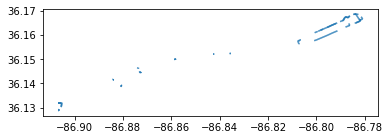

In [37]:
offpeak_summer_inbound.plot()

<AxesSubplot:>

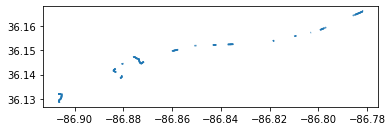

In [38]:
offpeak_inschool_inbound.plot()

<AxesSubplot:>

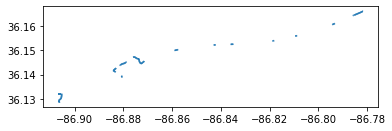

In [51]:
morning_summer_inbound.plot()

<AxesSubplot:>

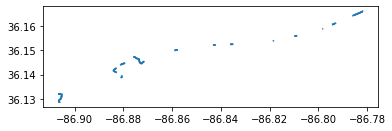

In [52]:
morning_inschool_inbound.plot()

# Start of M-F, 9am-2:30am, OFFPEAK OUTBOUND df, sorted by 30 day chunks Jan 25-July26

In [ ]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '0',
    'startDate': '01-25-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '02-24-2022',
    'endTime' : '14:30',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '0',
    'startDate': '01-25-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '02-24-2022',
    'endTime' : '14:30',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

jantofeb_offpeak_outbound = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "1/25/22-2/24/22")

#jantofeb_offpeak_inbound = jantofeb_offpeak_inbound.loc[jantofeb_offpeak_inbound['countForSegment'] > jantofeb_offpeak_inbound['countForSegment'].max()/2]

jantofeb_offpeak_outbound

In [ ]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '0',
    'startDate': '02-25-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '03-26-2022',
    'endTime' : '14:30',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '0',
    'startDate': '02-25-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '03-26-2022',
    'endTime' : '14:30',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

febtomar_offpeak_outbound = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "2/25/22-3/26/22")

#mfam_febtomar = mfam_febtomar.loc[mfam_febtomar['countForSegment'] > mfam_febtomar['countForSegment'].max()/2]

febtomar_offpeak_outbound

In [ ]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '0',
    'startDate': '03-27-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '04-26-2022',
    'endTime' : '14:30',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '0',
    'startDate': '03-27-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '04-26-2022',
    'endTime' : '14:30',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

martoapr_offpeak_outbound = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "3/27/22-4/26/22")

#mfam_martoapr = mfam_martoapr.loc[mfam_martoapr['countForSegment'] > mfam_martoapr['countForSegment'].max()/2]

martoapr_offpeak_outbound

In [ ]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '0',
    'startDate': '04-27-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '05-25-2022',
    'endTime' : '14:30',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '0',
    'startDate': '04-27-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '05-25-2022',
    'endTime' : '14:30',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

aprtomay_offpeak_outbound = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "4/27/22-5/25/22")

#mfam_aprtomay = mfam_aprtomay.loc[mfam_aprtomay['countForSegment'] > mfam_aprtomay['countForSegment'].max()/2]

aprtomay_offpeak_outbound

In [ ]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '0',
    'startDate': '05-26-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '06-25-2022',
    'endTime' : '14:30',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '0',
    'startDate': '05-26-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '06-25-2022',
    'endTime' : '14:30',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

maytojun_offpeak_outbound = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "4/27/22-5/25/22")

#mfam_maytojun = mfam_maytojun.loc[mfam_maytojun['countForSegment'] > mfam_maytojun['countForSegment'].max()/2]

maytojun_offpeak_outbound

In [ ]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

params = {
    'direction': '0',
    'startDate': '06-26-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '07-26-2022',
    'endTime' : '14:30',
    'format' : 'geojson',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

params1 = {
    'direction': '0'
    'startDate': '06-26-2022',
    'beginTime' : '09:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '07-26-2022',
    'endTime' : '14:30',
    'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
    'resolution': 'hiRes',
}

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

juntojul_offpeak_outbound = concat_frames_columns(requests.get(URL, params = params, headers = headers),
                                     requests.get(URL, params = params1, headers = headers), "4/27/22-5/25/22")

#mfam_juntojul = mfam_juntojul.loc[mfam_juntojul['countForSegment'] > mfam_juntojul['countForSegment'].max()/2]

juntojul_offpeak_outbound

In [ ]:
offpeak_inschool_out = pd.concat([jantofeb_offpeak_outbound, febtomar_offpeak_outbound, martoapr_offpeak_outbound, aprtomay_offpeak_outbound])
offpeak_inschool = offpeak_inschool.reset_index()

offpeak_inschool

In [ ]:
offpeak_inschool = pd.concat([jantofeb_offpeak_inbound, febtomar_offpeak_inbound, martoapr_offpeak_inbound, aprtomay_offpeak_inbound])
offpeak_inschool = offpeak_inschool.reset_index()

offpeak_inschool

In [ ]:
offpeak_summer_in = pd.concat([maytojun_offpeak_inbound, juntojul_offpeak_inbound])
offpeak_summer_in = offpeak_summer_in.reset_index()

offpeak_summer_outboun

# Start of M-F outbound df, sorted by 30 day chunks Jan 25-July26

In [39]:
# URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

# params = {
#     'direction': '0',
#     'startDate': '01-25-2022',
#     'beginTime' : '06:00',
#     'daysOfWeek' : '1,2,3,4,5',
#     'endDate' : '02-24-2022',
#     'endTime' : '09:00',
#     'format' : 'geojson',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'resolution': 'hiRes',
# }

# params1 = {
#     'direction': '0',
#     'startDate': '01-25-2022',
#     'beginTime' : '06:00',
#     'daysOfWeek' : '1,2,3,4,5',
#     'endDate' : '02-24-2022',
#     'endTime' : '09:00',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'resolution': 'hiRes',
# }

# headers = {'Authorization': Authorization,
#           'Content-Type': 'application/json'}

# janfeboutbound = concat_frames(requests.get(URL, params = params, headers = headers), requests.get(URL, params = params1, headers = headers))

# janfeboutbound = janfeboutbound.loc[janfeboutbound['countForSegment'] > janfeboutbound['countForSegment'].max()/2]

# janfeboutbound

In [40]:
# URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

# params = {
#     'direction': '0',
#     'startDate': '02-25-2022',
#     'beginTime' : '06:00',
#     'daysOfWeek' : '1,2,3,4,5',
#     'endDate' : '03-26-2022',
#     'endTime' : '09:00',
#     'format' : 'geojson',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'resolution': 'hiRes',
# }

# params1 = {
#     'direction': '0',
#     'startDate': '02-25-2022',
#     'beginTime' : '06:00',
#     'daysOfWeek' : '1,2,3,4,5',
#     'endDate' : '03-26-2022',
#     'endTime' : '09:00',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'resolution': 'hiRes',
# }

# headers = {'Authorization': Authorization,
#           'Content-Type': 'application/json'}

# febmaroutbound = concat_frames(requests.get(URL, params = params, headers = headers), requests.get(URL, params = params1, headers = headers))

# febmaroutbound = febmaroutbound.loc[febmaroutbound['countForSegment'] > febmaroutbound['countForSegment'].max()/2]

# febmaroutbound

In [41]:
# URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

# params = {
#     'direction': '0',
#     'startDate': '03-27-2022',
#     'beginTime' : '06:00',
#     'daysOfWeek' : '1,2,3,4,5',
#     'endDate' : '04-26-2022',
#     'endTime' : '09:00',
#     'format' : 'geojson',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'resolution': 'hiRes',
# }

# params1 = {
#     'direction': '0',
#     'startDate': '03-27-2022',
#     'beginTime' : '06:00',
#     'daysOfWeek' : '1,2,3,4,5',
#     'endDate' : '04-26-2022',
#     'endTime' : '09:00',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'resolution': 'hiRes',
# }

# headers = {'Authorization': Authorization,
#           'Content-Type': 'application/json'}

# maraproutbound = concat_frames(requests.get(URL, params = params, headers = headers), requests.get(URL, params = params1, headers = headers))

# maraproutbound = maraproutbound.loc[maraproutbound['countForSegment'] > maraproutbound['countForSegment'].max()/2]

# maraproutbound

In [42]:
# URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

# params = {
#     'direction': '0',
#     'startDate': '04-27-2022',
#     'beginTime' : '06:00',
#     'daysOfWeek' : '1,2,3,4,5',
#     'endDate' : '05-25-2022',
#     'endTime' : '09:00',
#     'format' : 'geojson',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'resolution': 'hiRes',
# }

# params1 = {
#     'direction': '0',
#     'startDate': '04-27-2022',
#     'beginTime' : '06:00',
#     'daysOfWeek' : '1,2,3,4,5',
#     'endDate' : '05-25-2022',
#     'endTime' : '09:00',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'resolution': 'hiRes',
# }

# headers = {'Authorization': Authorization,
#           'Content-Type': 'application/json'}

# aprmayoutbound = concat_frames(requests.get(URL, params = params, headers = headers), requests.get(URL, params = params1, headers = headers))

# aprmayoutbound = aprmayoutbound.loc[aprmayoutbound['countForSegment'] > aprmayoutbound['countForSegment'].max()/2]

# aprmayoutbound

In [43]:
# URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

# params = {
#     'direction': '0',
#     'startDate': '05-26-2022',
#     'beginTime' : '06:00',
#     'daysOfWeek' : '1,2,3,4,5',
#     'endDate' : '06-25-2022',
#     'endTime' : '09:00',
#     'format' : 'geojson',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'resolution': 'hiRes',
# }

# params1 = {
#     'direction': '0',
#     'startDate': '05-26-2022',
#     'beginTime' : '06:00',
#     'daysOfWeek' : '1,2,3,4,5',
#     'endDate' : '06-25-2022',
#     'endTime' : '09:00',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'resolution': 'hiRes',
# }

# headers = {'Authorization': Authorization,
#           'Content-Type': 'application/json'}

# mayjunoutbound = concat_frames(requests.get(URL, params = params, headers = headers), requests.get(URL, params = params1, headers = headers))

# mayjunoutbound = mayjunoutbound.loc[mayjunoutbound['countForSegment'] > mayjunoutbound['countForSegment'].max()/2]

# mayjunoutbound

In [44]:
# URL = 'https://api.goswift.ly/speed-map/nashville/route/50'

# params = {
#     'direction': '0',
#     'startDate': '06-26-2022',
#     'beginTime' : '06:00',
#     'daysOfWeek' : '1,2,3,4,5',
#     'endDate' : '07-26-2022',
#     'endTime' : '09:00',
#     'format' : 'geojson',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'resolution': 'hiRes',
# }

# params1 = {
#     'direction': '0',
#     'startDate': '06-26-2022',
#     'beginTime' : '06:00',
#     'daysOfWeek' : '1,2,3,4,5',
#     'endDate' : '07-26-2022',
#     'endTime' : '09:00',
#     'excludeDates': '01-17-2022,02-18-2022,03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022,04-14-2022,04-15-2022,05-30-2022,07-04-2022',
#     'resolution': 'hiRes',
# }

# headers = {'Authorization': Authorization,
#           'Content-Type': 'application/json'}

# junjuloutbound = concat_frames(requests.get(URL, params = params, headers = headers), requests.get(URL, params = params1, headers = headers))

# junjuloutbound = junjuloutbound.loc[junjuloutbound['countForSegment'] > junjuloutbound['countForSegment'].max()/2]

# junjuloutbound